In [9]:
%pip install -U -q 'google-generativeai>=0.8.3'

Note: you may need to restart the kernel to use updated packages.


In [10]:
import google.generativeai as genai
from dotenv import load_dotenv
import os
load_dotenv()

True

In [11]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## List of Tunable Models

In [12]:

for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


In [13]:
%pip install scikit-learn

  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 2.0 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

In [24]:
newsgroups_train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [23]:
newsgroups_train.target_names[0]

'alt.atheism'

## Preprocessing Data

In [25]:
%pip install -U -q 'pandas'

Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import email
import re

In [46]:
def process_row(row):
    msg=email.message_from_string(row)
    text=f"{msg['Subject']}\n\n{msg.get_payload()}"
    #remove any emails
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    #truncate length
    text = text[:40000]
    return text

def preprocess_data(data):
    df = pd.DataFrame({"text": data.data, "label": data.target})
    df["text"]=df["text"].apply(process_row)
    df["class_name"]=df["label"].map(lambda x:data.target_names[x])

    return df
    

In [47]:
df_train = preprocess_data(newsgroups_train)
df_test = preprocess_data(newsgroups_test)

In [48]:
df_train.head()

,text,label,class_name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


# Sampling Data
We only sample 50 rows as with this technique (PEFT-parameter-efficient fine-tuning) the model can train on relatively small number of parameters.

In [50]:
TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10

CLASSES_TO_KEEP = "^rec|^sci"

def sample_data(df, num_samples, classes_to_keep):
    df = df.groupby("label")[df.columns].apply(lambda x: x.sample(num_samples, replace=True)).reset_index(drop=True)
    df = df[df["class_name"].str.contains(classes_to_keep)]
    df["class_name"]=df["class_name"].astype("category")
    return df
    

In [51]:
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [52]:
df_train.head()

,text,label,class_name
350,Re: No-Haggle Deals...Save $$???\n\nA local de...,7,rec.autos
351,differences in insurance companies' rates\n\nI...,7,rec.autos
352,"Re: BMW 3 series for 94?\n\nFrom article <>, b...",7,rec.autos
353,Re: Did US drive on the left?\n\nRob Reilly:\n...,7,rec.autos
354,"Re: LH car order delay\n\nIn article <>, writ...",7,rec.autos


## Baseline Performance

In [57]:
sample_idx = 0
sample_row = process_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


In [58]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

You're right, the 1988-1989 Bonneville models can be confusing! Let's break down the differences and talk about values:

**Model Breakdown:**

* **LE:**  The "Luxury Edition" was the base model. It featured comfortable cloth upholstery, power steering, and basic amenities. 
* **SE:**  The "Special Edition" had a more upscale look, with some minor trim and interior upgrades.
* **LSE:**  The "Luxury Special Edition" added more features, like leather seats, power windows, and sometimes power locks.
* **SSE:**  The "Sport Special Edition" was the sporty version, offering a more powerful engine (usually the 3.8L V6), a sportier suspension, and unique cosmetic touches.
* **SSEi:**  The "Sport Special Edition Injection" was the top-of-the-line model. It had the same powerful 3.8L V6 but with electronic fuel injection for better performance.

**Performance:**

* **Engines:**  The 1988-1989 Bonnevilles came with either a 3.8L V6 or a 5.0L V8. The 3.8L was adequate, but the 5.0L provided much mo

### Trying Zero shot prompt

In [59]:
prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

It's highly likely this message originates from a **newsgroup related to Pontiac Bonnevilles**.  

Here's why:

* **Specific Model References:** The message mentions specific Bonneville trims (LE, SE, LSE, SSE, SSEi), indicating the sender is interested in this particular car model.
* **Book Value and Demand:**  The inquiries about book value and market demand are typical questions asked in car-related newsgroups.
* **Seasonal Buying:** The mention of "mid-spring early summer" as the best time to buy is a common observation in car purchasing discussions.

**Possible newsgroups:**

* **alt.autos.pontiac:** This newsgroup would be the most relevant for Bonneville-specific discussions.
* **rec.autos.cars:** This group covers a broader range of car topics but would still be suitable for the message's content. 
* **comp.sys.ibm.pc.hardware.misc:**  If the message was posted in the context of a specific feature or technical aspect of the Bonneville, it might appear in this hardware-related g

### Picking up relevant output from prompt text.

In [65]:
system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

def predict_label(post: str)->str:
    response = instructed_model.generate_content(post)
    return response.text.strip()


In [66]:
prediction = predict_label(sample_row)
print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


## Finetuning

In [68]:
import random

model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="text",  # the column to use as input
    output_key="class_name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

### Tuning

In [69]:
%pip install -U -q seaborn

Note: you may need to restart the kernel to use updated packages.


1
1
1
Done! The model is ACTIVE


<Axes: xlabel='step', ylabel='mean_loss'>

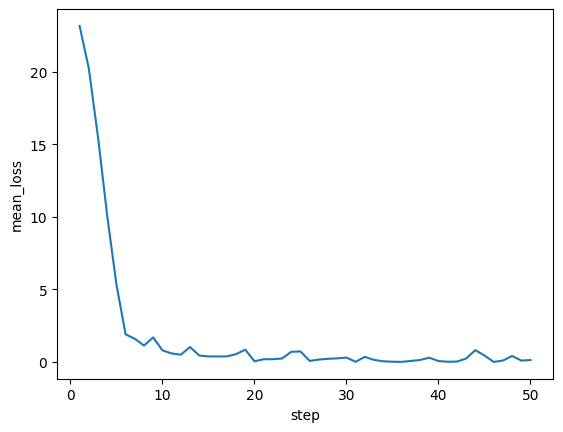

In [70]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")

In [71]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


In [72]:
new_text = """
I am really into movies.
My favorite genre is Drama and sometimes action.
I like to watch movies all days on a weekend.

Let me know the best movies of this year please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.electronics


In [ ]:
tuned_models = genai.list_tuned_models()

# Print the names of the tuned models
for model in tuned_models:
    print(model.display_name)